In [533]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale 
from sklearn import model_selection
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [551]:
def area(x):
    if x == "Los Angeles" or x == "Anaheim" or x == "Long Beach":
        return "Los Angeles"
    elif x == "Dallas" or x == "Arlington" or x == "Fort Worth":
        return "Dallas"
    elif x == "Chicago" or x == "Engin" or x == "Naperville":
        return "Chicago"
    else:
        return "DC"
    
metro = pd.read_csv('../data/final/metro/metro_all.csv')
metro = metro.drop(["Unnamed: 0"], axis = 1)
shuffled = metro.sample(frac=1).reset_index().drop(["index"], axis = 1).drop(["dist_shopping.1"], axis = 1).drop(["Housing Price/SQ Ft"], axis = 1)
shuffled["City"] = shuffled["City"].apply(area)
shuffled = pd.get_dummies(shuffled, columns=["City"])
X = shuffled.drop("Norm Price", 1)
y = shuffled["Norm Price"]

/var/folders/cm/_n101lcd24v_khq7567y13rm0000gn/T/ipykernel_12419/4273224332.py:16: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X = shuffled.drop("Norm Price", 1)


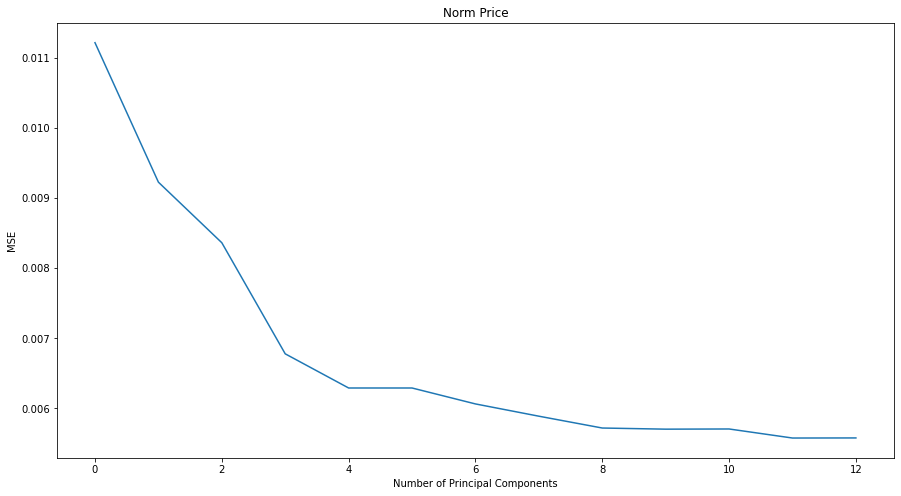

In [552]:
#scale predictor variables
pca = PCA()
X_reduced = pca.fit_transform(scale(X))

#define cross validation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

regr = LinearRegression()
mse = []

# Calculate MSE with only the intercept
score = -1*model_selection.cross_val_score(regr,
           np.ones((len(X_reduced),1)), y, cv=cv,
           scoring='neg_mean_squared_error').mean()    
mse.append(score)

# Calculate MSE using cross-validation, adding one component at a time
for i in np.arange(1, 13):
    score = -1*model_selection.cross_val_score(regr,
               X_reduced[:,:i], y, cv=cv, scoring='neg_mean_squared_error').mean()
    mse.append(score)
    
# Plot cross-validation results    
plt.plot(mse)
plt.xlabel('Number of Principal Components')
plt.ylabel('MSE')
plt.title('Norm Price')

np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

rmse = list()
for i in range(1, 13):
    #split the dataset into training (70%) and testing (30%) sets
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0) 

    #scale the training and testing data
    X_reduced_train = pca.fit_transform(scale(X_train))
    X_reduced_test = pca.transform(scale(X_test))[:,:i]

    #train PCR model on training data 
    regr = LinearRegression()
    regr.fit(X_reduced_train[:,:i], y_train)

    #calculate RMSE
    pred = regr.predict(X_reduced_test)
    rmse.append(np.sqrt(mean_squared_error(y_test, pred)))


Text(0.5, 1.0, 'Norm Price')

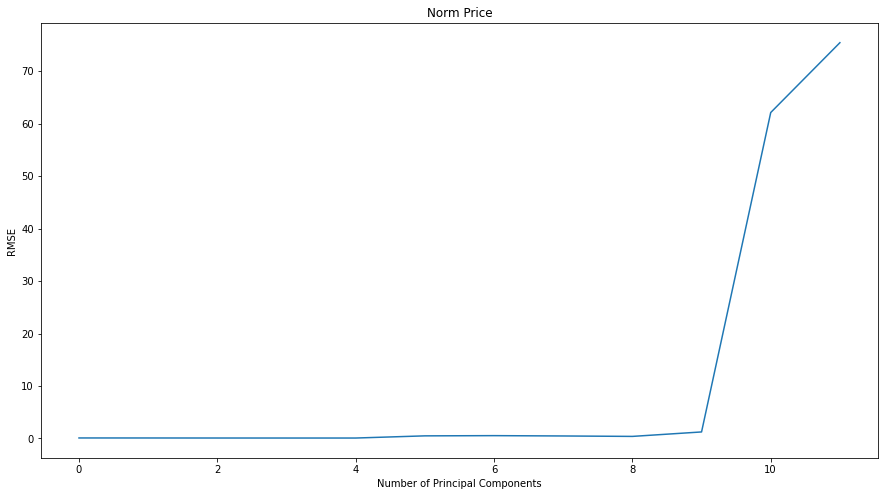

In [553]:
# Plot RMSE results    
plt.plot(rmse)
plt.xlabel('Number of Principal Components')
plt.ylabel('RMSE')
plt.title('Norm Price')